In [3]:
from netCDF4 import Dataset
import pandas as pd
import numpy as np
import matplotlib as mpl
import copy

import os, sys
import pickle as pkl
from scipy import interpolate
import scipy as sp

from hypnotoad import tokamak
from hypnotoad.core.mesh import BoutMesh

sys.path.append(r"C:\Users\mikek\OneDrive\Project\DLS\DLS-git")
from LRBv21 import LRBv21
from AnalyticCoolingCurves import *
from unpackConfigurationsMK import *
from refineGrid import refineGrid
from Morph import Profile, Morph

onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))

from DLS.postprocess import *

from code_comparison.solps_pp import *
import general.plotstyle
from step_wall_details import wall_details
%matplotlib inline

%load_ext autoreload
%autoreload 2


In [2]:
wall_details?

Object `wall_details` not found.


# Read balance file

In [2]:
balance_path = r"C:\Users\mikek\OneDrive\Project\DLS\from_stuart\2023-07-11 - SPR45 balance file\balance.nc"
eqb = dict()
eqb["SPR45"] = dict()

for side in ["il", "ol", "iu", "ou"]: # Inner lower, outer lower.
    eqb["SPR45"][side] = unpackConfigurationMK(File = balance_path, Type = side, sepadd=0, resolution = 2000)
    
    keys = list(eqb["SPR45"][side].keys())
    for key in keys:
        
        if key not in ["Bpol", "Btot", "Xpoint", "Spol", "S", "R", "Z"]:
            eqb["SPR45"][side].pop(key, None)
        
# file_write(eqb, "equilibrium.pkl")

# Read SOLPS case

In [7]:
balancepath =  r"C:\Users\mikek\OneDrive\Project\DLS\from_david\2023-11-30 - New SPR45 balance file"

slc = self = SOLPScase(balancepath)

Text(0, 0.5, 'Z [m]')

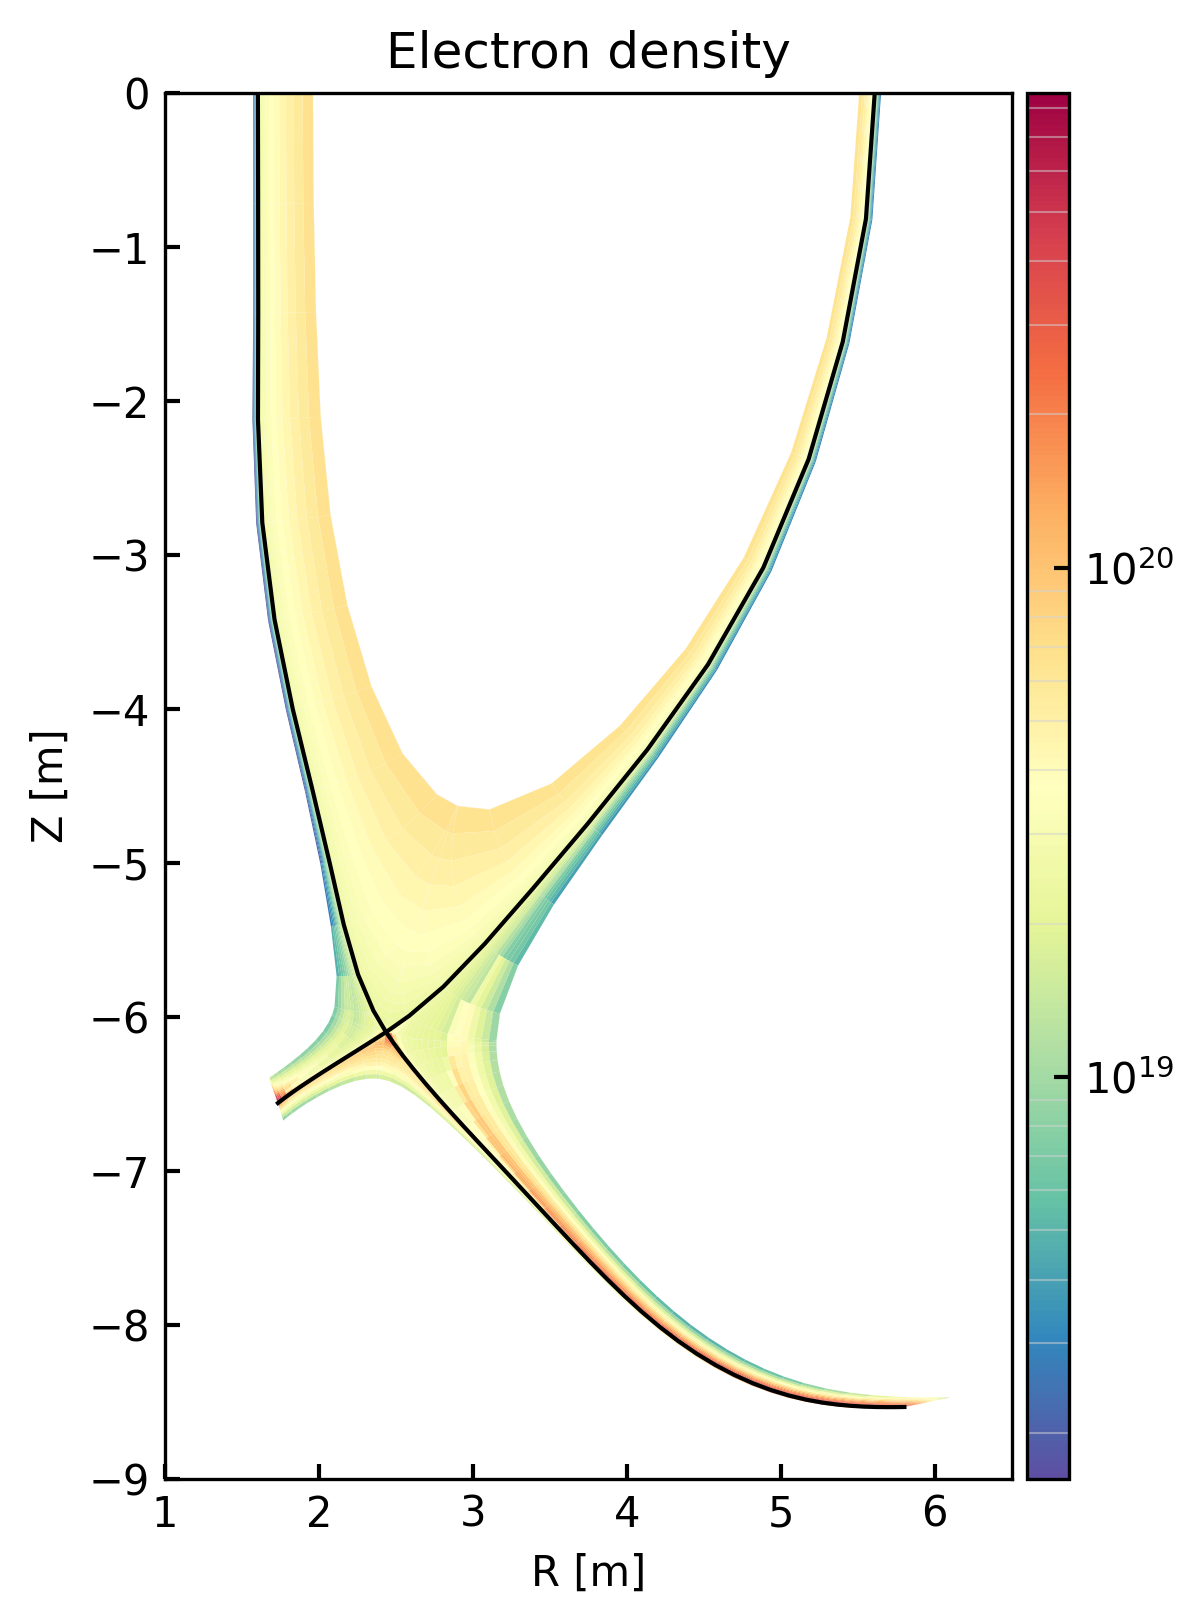

In [23]:
fig, ax = plt.subplots(dpi = 300, figsize = (4,6), sharey = True)

slc.plot_2d(param = "ne",  ax = ax, fig = fig, 
            linewidth = 0, antialias = True, grid_only = False, vmax = None, logscale = True,
            custom_cmap = "Spectral_r", cbar = True, axis_labels = False, alpha = 1)

ax.set_xlim(1.0, 6.5)
ax.grid(False)
ax.set_ylim(-9, 0)
ax.set_title("Electron density")
ax.set_xlabel("R [m]")
ax.set_ylabel("Z [m]")

In [ ]:
self = wall_details(
    # gfile = r"C:\Users\mikek\OneDrive\Project\DLS\SPR45details\AH_PI4_P5.geqdsk",
    gfile = r"C:\Users\mikek\OneDrive\Project\DLS\SPR45details\AH_PI4_P5-LATEST.geqdsk",
    wfile = r"C:\Users\mikek\OneDrive\Project\DLS\SPR45details\SPR45.txt",
    monoblock = {"g":0.5e-3,"l":2e-3,"h":0.3e-3,"p":0.028},
    debug = True,
    fig = fig,
    ax = ax,
    custom_plot = True
)

Text(0, 0.5, 'Z [m]')

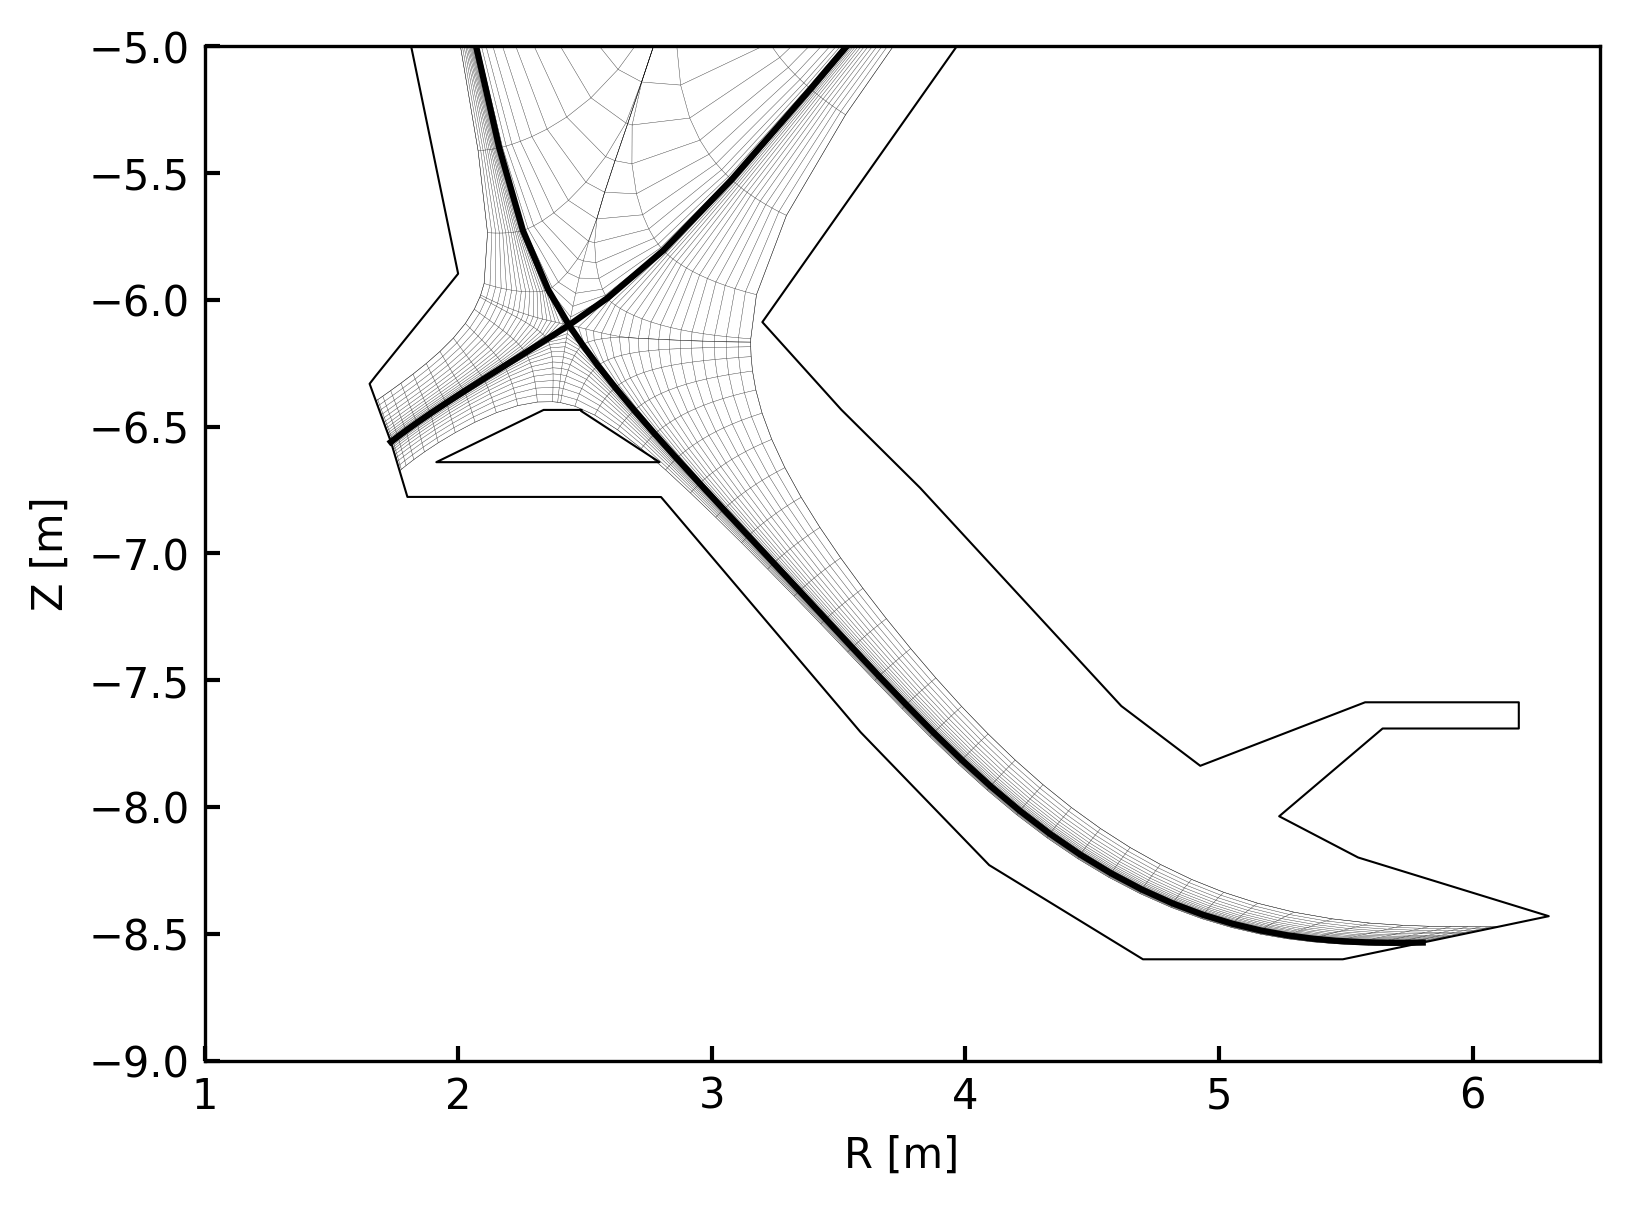

In [11]:
rwall, zwall = np.loadtxt(r"C:\Users\mikek\OneDrive\Project\DLS\SPR45details\spr45-2024-02-16.txt", unpack = True)
domeR = np.array([2486,2337,1914,2794,2486])
domeZ = np.array([6434,6434,6640,6640,6439])

fig, ax = plt.subplots(dpi = 300, figsize = (6,8), sharey = True)

cmap = mpl.colors.LinearSegmentedColormap.from_list("custom", ["white", "#FF0000", "#00B6FF"], N=3)
slc.plot_2d(param = f"",  ax = ax, 
            linewidth = 0.1, antialias = True, grid_only = True, vmax = 1,
            custom_cmap = cmap, cbar = False, axis_labels = False, alpha = 0.5)


ax.plot(np.array(rwall), np.array(zwall), color = "black", lw = 0.5)
ax.plot(domeR/1000, -domeZ/1000, color = "black", lw = 0.5)
ax.set_aspect("equal")
ax.set_xlim(1.0, 6.5)
ax.grid(False)
ax.set_ylim(-9, -5)
ax.set_xlabel("R [m]")
ax.set_ylabel("Z [m]")

# Equilibrium

In [16]:
from freegs import geqdsk
from freegs import machine
from freegs.plotting import plotEquilibrium
# Reading MAST equilibrium, up-down symmetric coils
tokamak = machine.MASTU()

In [ ]:
with open(r"C:\Users\mikek\OneDrive\Project\DLS\from_stuart\2024-01-15 - SPR45 correct equilibrium\AH_PI4_P5.geqdsk") as f:
  eq = geqdsk.read(f, tokamak, show=True)
freegs.plotEquilibrium(eq)

start
start


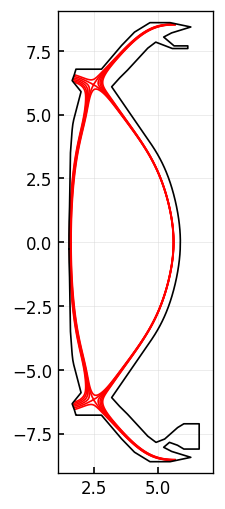

In [5]:
fig, ax = plt.subplots()
self = wall_details(
    gfile = r"C:\Users\mikek\OneDrive\Project\DLS\SPR45details\AH_PI4_P5-LATEST.geqdsk",
    wfile = r"C:\Users\mikek\OneDrive\Project\DLS\SPR45details\spr45-2024-02-16.txt",
    monoblock = {"g":0.5e-3,"l":2e-3,"h":0.3e-3,"p":0.028},
    debug = True,
    fig = fig,
    ax = ax,
    custom_plot = True
)



In [37]:
def biased_linspace(start, stop, num, bias=1.0, direction='forward'):
	# Generate a regular linspace
	regular_space = np.linspace(0, 1, num)
	# Adjust the direction of bias
	if direction == 'forward':
		biased_space = np.exp(bias * regular_space) - 1
	elif direction == 'backward':
		biased_space = np.exp(-bias * regular_space) - 1
	else:
		raise ValueError("Invalid direction. Choose 'forward' or 'backward'.")
	# Rescale to the desired range
	scaled_space = (biased_space - biased_space.min()) / (biased_space.max() - biased_space.min())
	return start + scaled_space * (stop - start)

levels_core = list(biased_linspace(0.01, 0.989, 20, 2, direction = "backward"))

levels_core

[0.989,
 0.8758761359140728,
 0.7740547456164873,
 0.6824065721218289,
 0.5999151851906663,
 0.5256657085415398,
 0.458834673353955,
 0.3986808855319804,
 0.3445372054412173,
 0.2958031489517606,
 0.25193822772852204,
 0.21245595490895489,
 0.17691844968774662,
 0.14493158097026196,
 0.11614059623509855,
 0.09022618712736029,
 0.06690094814784628,
 0.04590618916300877,
 0.027009066384608142,
 0.01]

In [ ]:
levels_core = list(np.linspace(0.01, 0.99, 50))
levels_sep = list(np.linspace(0.99,1.01, 20))
levels_sol = list(np.linspace(1.01, 1.2, 50))
levels=levels_core + levels_sep + levels_sol,

levels

start
start


Text(0, 0.5, 'Z [m]')

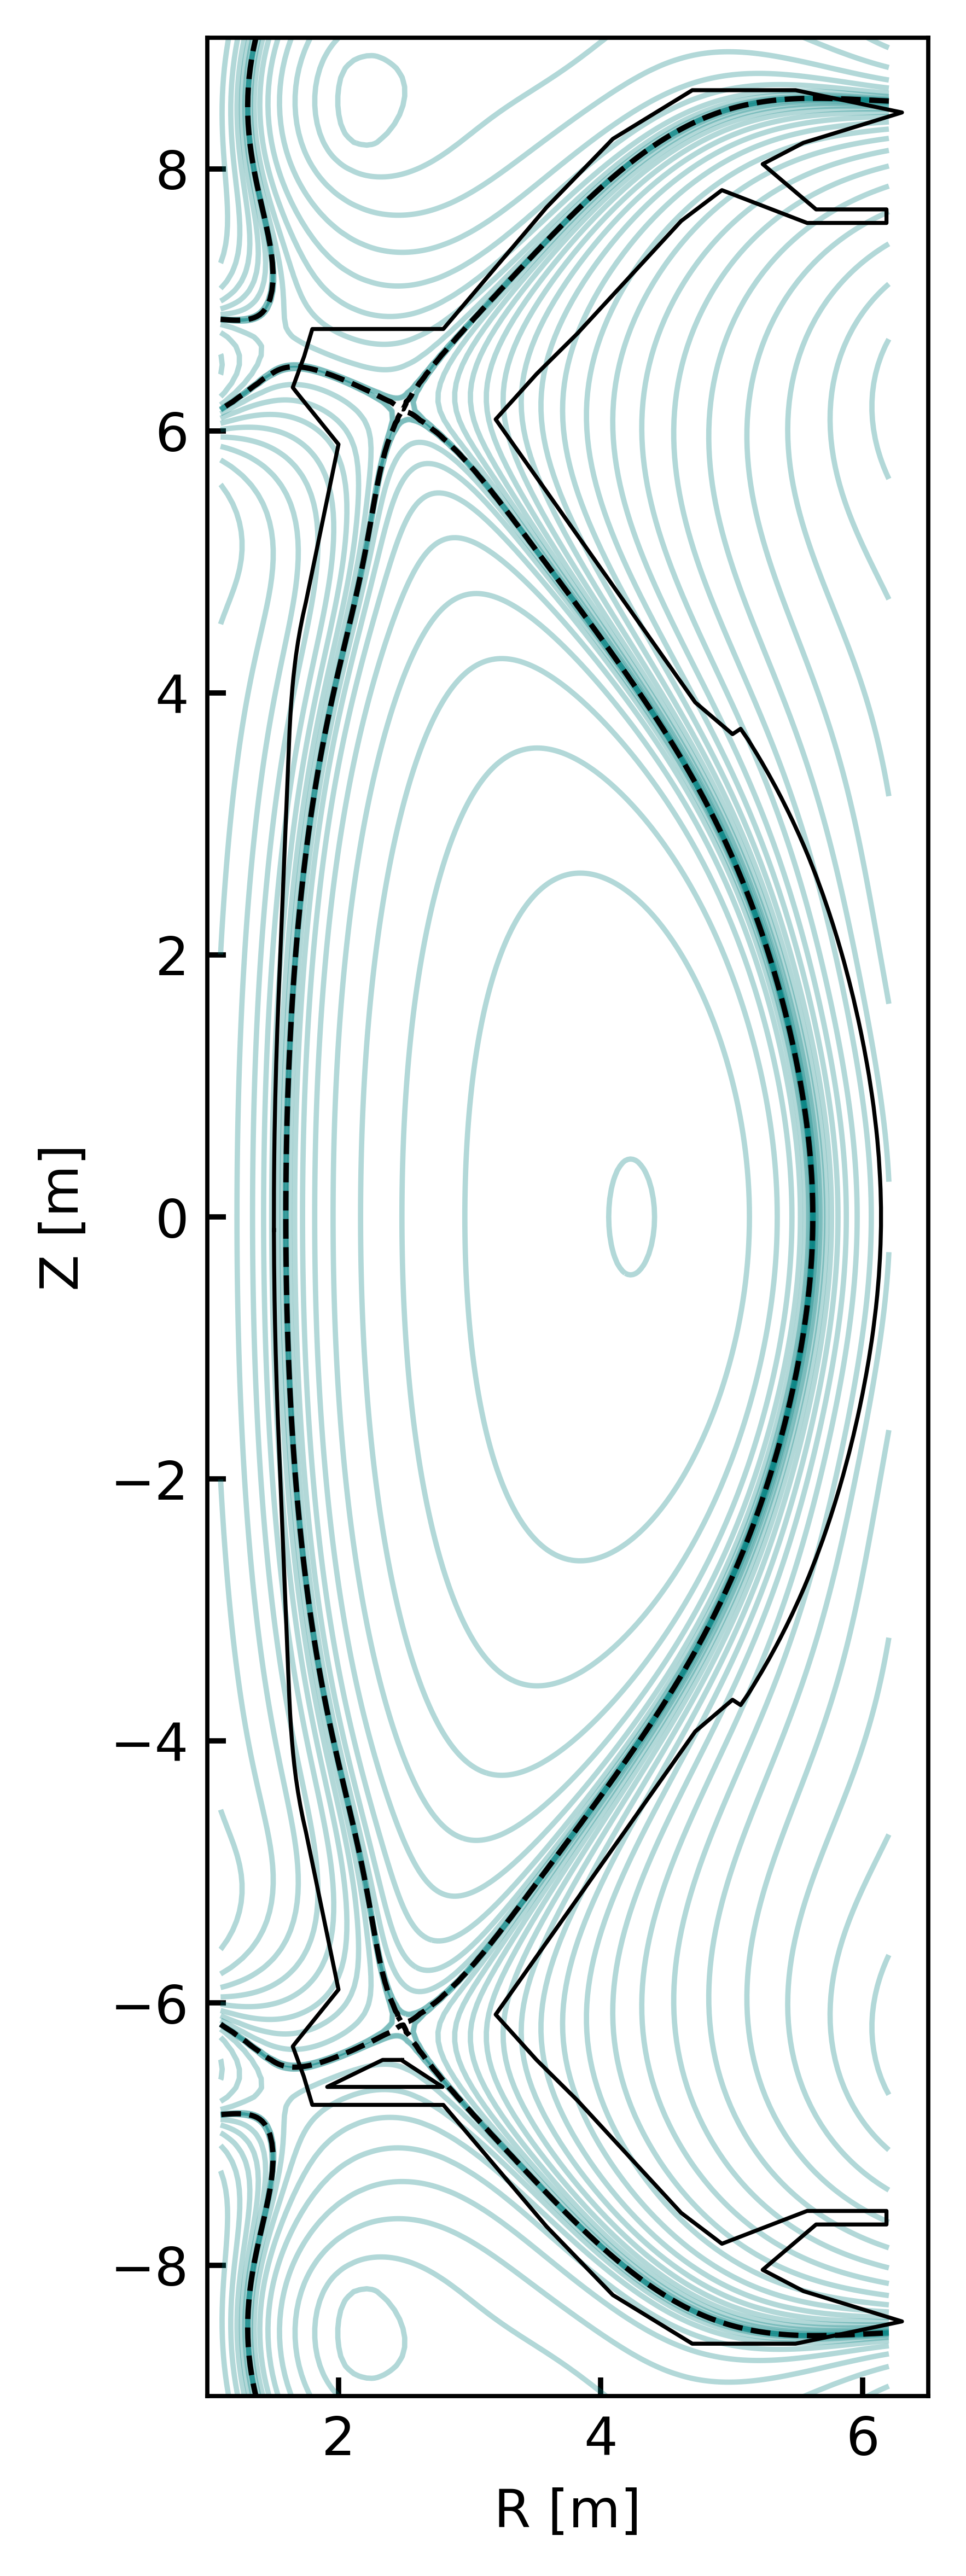

In [78]:
rwall, zwall = np.loadtxt(r"C:\Users\mikek\OneDrive\Project\DLS\SPR45details\spr45-2024-02-16.txt", unpack = True)
domeR = np.array([2486,2337,1914,2794,2486])
domeZ = np.array([6434,6434,6640,6640,6439])

fig, ax = plt.subplots(dpi = 700, figsize = (6,8), sharey = True)

cmap = mpl.colors.LinearSegmentedColormap.from_list("custom", ["white", "#FF0000", "#00B6FF"], N=3)
# slc.plot_2d(param = f"",  ax = ax, 
#             linewidth = 0.1, antialias = True, grid_only = True, vmax = 1,
#             custom_cmap = cmap, cbar = False, axis_labels = False, alpha = 0.5)

self = wall_details(
    gfile = r"C:\Users\mikek\OneDrive\Project\DLS\SPR45details\AH_PI4_P5-LATEST.geqdsk",
    wfile = r"C:\Users\mikek\OneDrive\Project\DLS\SPR45details\spr45-2024-02-16.txt",
    monoblock = {"g":0.5e-3,"l":2e-3,"h":0.3e-3,"p":0.028},
    debug = True,
    fig = fig,
    ax = ax,
    custom_plot = True
)

# slc.plot_separatrix(ax, c = "k", ls = "--")


ax.plot(np.array(rwall), np.array(zwall), color = "black", lw = 0.75, zorder = 100)
ax.plot(domeR/1000, -domeZ/1000, color = "black", lw = 0.75, zorder = 100)
ax.set_aspect("equal")
ax.set_xlim(1.0, 6.5)
ax.grid(False)
# ax.set_ylim(-9, 0.1)
ax.set_ylim(-9, 9)
ax.set_xlabel("R [m]")
ax.set_ylabel("Z [m]")

# ax.set_xlim(1.0, 6.5)
# ax.set_ylim(-9, -5)